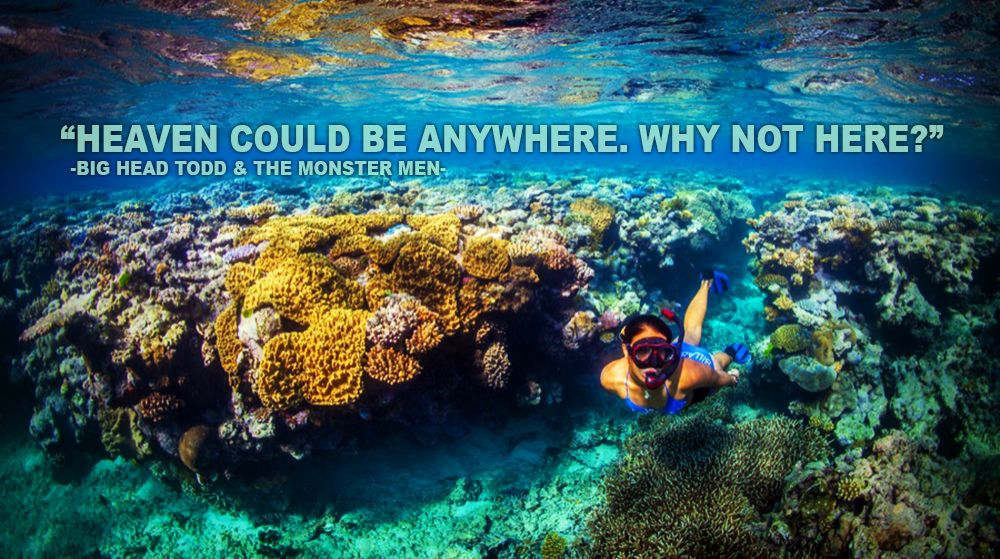

# [COTS]TFOD2(API Setup + Faster RCNN)

## Goal of the Competition
The goal of this competition is to accurately identify starfish in real-time by building an object detection model trained on underwater videos of coral reefs.

## Context
Australia's stunningly beautiful Great Barrier Reef is the world’s largest coral reef and home to 1,500 species of fish, 400 species of corals, 130 species of sharks, rays, and a massive variety of other sea life.
Unfortunately, the reef is under threat, in part because of the overpopulation of one particular starfish – the coral-eating crown-of-thorns starfish (or COTS for short). Scientists, tourism operators and reef managers established a large-scale intervention program to control COTS outbreaks to ecologically sustainable levels.


## Changes in the pipeline config are mentioned below
- num_classes =1
- image width and height
- score_threshold = 0.3 for getting only threshold above confidence score of 30%
- optimizer -> ADDED a custom manual training step optimizer which divides Lr by 10
- fine_tune_checkpoint_type -> from classification to detection or else during training it will it stop after feature extraction
- use_bfloat16 = False since we are training in gpu
- batch_size =1 can't afford higher batchsize or get ready to get rekt. Good configuration like 4x v100 can use batch_size = 8 or even 16


> Note: `TF2 API pre-trained models were trained on TPU, while using a gpu try to keep a low batch size to avoid OOM errors` 
> Note2: 'Always better to run these models on a local environment or colabpro connected to your gdrive'

## Installation
Install the dependencies

## Contribute

Want to contribute? you can always copy and edit

More on TF OD API at

```sh
https://github.com/tensorflow/models/tree/master/research/object_detection
```

## Contact

- [Click here ](https://twitter.com/bambose_) - to connect me on twitter


## Faster RCNN architecture


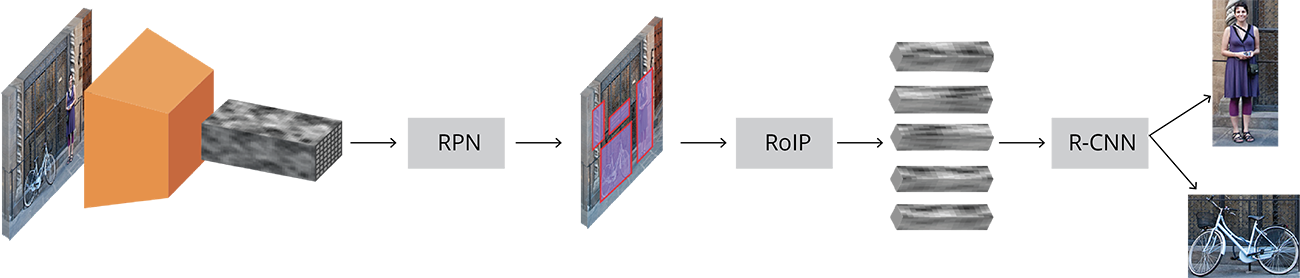


## Thanks
Major thanks to @Khanh for providing the base notebook.
You can visit his profile here.
[@Khanh ](https://www.kaggle.com/khanhlvg)

## PS - Inference notebook out soon







In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!git clone https://github.com/tensorflow/models
    
# Check out a certain commit to ensure that future changes in the TF ODT API codebase won't affect this notebook.
!cd models && git checkout new_branch

### EASY SETUP CREDITS https://www.kaggle.com/khanhlvg/cots-detection-w-tensorflow-object-detection-api
### WANT TO SETUP API ON COLAB  https://colab.research.google.com/drive/1lfWnuBZXWmC3DiLWmYs56SPBW4RvWYkp?usp=sharing create a copy


In [ ]:
%%bash
cd models/research

# Compile protos.
protoc object_detection/protos/*.proto --python_out=.

wget https://storage.googleapis.com/odml-dataset/others/setup.py
pip install -q --user .

# Test if the Object Dectection API is working correctly
python object_detection/builders/model_builder_tf2_test.py

In [ ]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time

from PIL import Image, ImageDraw

# Import the library that is used to submit the prediction result.
INPUT_DIR = '/kaggle/input/tensorflow-great-barrier-reef/'
sys.path.insert(0, INPUT_DIR)
import greatbarrierreef

In [ ]:
TRAINING_RATIO = 0.75

data_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# Split the dataset so that no sequence is leaked from the training dataset into the validation dataset.
split_index = int(TRAINING_RATIO * len(data_df))
while data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    split_index += 1

# Shuffle both the training and validation datasets.
train_data_df = data_df.iloc[:split_index].sample(frac=1).reset_index(drop=True)
val_data_df = data_df.iloc[split_index:].sample(frac=1).reset_index(drop=True)

train_positive_count = len(train_data_df[train_data_df.annotations != '[]'])
val_positive_count = len(val_data_df[val_data_df.annotations != '[]'])

print('Training ratio (all samples):', 
      float(len(train_data_df)) / (len(train_data_df) + len(val_data_df)))
print('Training ratio (positive samples):', 
      float(train_positive_count) / (train_positive_count + val_positive_count))

In [ ]:
train_data_df = train_data_df[train_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_data_df))
val_data_df = val_data_df[val_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for validation:', len(val_data_df))

In [ ]:
#ALL THANKS TO @Khanh for providing the fast tf record conversion code , I'll release my xml-to-record kernel soon.
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util
import os

def create_tf_example(video_id, video_frame, data_df, image_path):
    """Create a tf.Example entry for a given training image."""
    full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')

    height = image.size[1] # Image height
    width = image.size[0] # Image width
    filename = f'{video_id}:{video_frame}'.encode('utf8') # Unique id of the image.
    encoded_image_data = None # Encoded image bytes
    image_format = 'jpeg'.encode('utf8') # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)

    rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
    for _, row in rows.iterrows():
        annotations = json.loads(row.annotations.replace("'", '"'))
        for annotation in annotations:
            xmins.append(annotation['x'] / width) 
            xmaxs.append((annotation['x'] + annotation['width']) / width) 
            ymins.append(annotation['y'] / height) 
            ymaxs.append((annotation['y'] + annotation['height']) / height) 

            classes_text.append('COTS'.encode('utf8'))
            classes.append(1)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example

def convert_to_tfrecord(data_df, tfrecord_filebase, image_path, num_shards = 10):
    """Convert the object detection dataset to TFRecord as required by the TF ODT API."""
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
            tf_record_close_stack, tfrecord_filebase, num_shards)
        
        for index, row in data_df.iterrows():
            if index % 500 == 0:
                print('Processed {0} images.'.format(index))
            tf_example = create_tf_example(row.video_id, row.video_frame, data_df, image_path)
            output_shard_index = index % num_shards
            output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
        
        print('Completed processing {0} images.'.format(len(data_df)))

!mkdir dataset
image_path = os.path.join(INPUT_DIR, 'train_images')

# Convert train images to TFRecord
print('Converting TRAIN images...')
convert_to_tfrecord(
  train_data_df,
  'dataset/cots_train',
  image_path,
  num_shards = 1
)

# Convert validation images to TFRecord
print('Converting VALIDATION images...')
convert_to_tfrecord(
  val_data_df,
  'dataset/cots_val',
  image_path,
  num_shards = 1
)

In [ ]:
#EASY PEASY LABEL MAPS.PBTXT FILE
label_map_str = """item {
  id: 1
  name: 'COTS'
}
"""


In [ ]:

with open('dataset/labelmap.pbtxt', 'w') as f:
  f.write(label_map_str)



In [ ]:
#downloading fasterrcnn model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz

In [ ]:
!tar -xzvf faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz

In [ ]:
%rm faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz

In [ ]:
from string import Template

config_file_template ="""

# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint

# This config is TPU compatible.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        width: 800
        height: 800
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
        share_box_across_classes: true
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.3
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
    use_static_shapes: true
    use_matmul_crop_and_resize: true
    clip_anchors_to_image: true
    use_static_balanced_label_sampler: true
    use_matmul_gather_in_matcher: true
  }
}

train_config: {
  batch_size: 1
  sync_replicas: true
  startup_delay_steps: 0
  replicas_to_aggregate: 8
  num_steps: $training_steps
  optimizer {
    momentum_optimizer: {
      learning_rate {
      manual_step_learning_rate {
          initial_learning_rate: 0.001
          schedule {
              step: 15000
              learning_rate: 0.0001
              }
          schedule {
              step: 25000
              learning_rate: 0.00001
              }
          
          schedule {
              step: 35000
              learning_rate: 0.000001
              }
          
          }
        }
      
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint: "/kaggle/working/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0"
  fine_tune_checkpoint_type: "detection"
  data_augmentation_options {
    random_horizontal_flip {
    }
  }

  data_augmentation_options {
    random_adjust_hue {
    }
  }

  data_augmentation_options {
    random_adjust_contrast {
    }
  }

  data_augmentation_options {
    random_adjust_saturation {
    }
  }

  data_augmentation_options {
     random_square_crop_by_scale {
      scale_min: 0.6
      scale_max: 1.3
    }
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  use_bfloat16: false  # works only on TPUs
}
train_input_reader: {
  label_map_path: "/kaggle/working/dataset/labelmap.pbtxt"
  tf_record_input_reader {
    input_path: "/kaggle/working/dataset/cots_train-?????-of-00001"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1;
}

eval_input_reader: {
  label_map_path: "/kaggle/working/dataset/labelmap.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/kaggle/working/dataset/cots_val-?????-of-00001"
  }
}
"""

In [ ]:
type(config_file_template)

In [ ]:
TRAINING_STEPS = 50000
PIPELINE_CONFIG_PATH='/kaggle/working/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/pipeline.config'

pipeline = Template(config_file_template).substitute(
    training_steps=TRAINING_STEPS)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

### CHANGES MADE IN PIPELINE CONFIG __ VV IMPORTANT
* num_classes =1
* image width and height
* score_threshold = 0.3 for getting only threshold above confidence score of 30%
* optimizer -> ADDED a custom manual training step optimizer which divides Lr by 10
* fine_tune_checkpoint_type -> from classification to detection or else during training it will it stop after feature extraction
* use_bfloat16 = False since we training in gpu
* batch_size =1 can't afford higher batchsize or get ready to get rekt. Good configuration like 4x v100 can use batch_size = 8 or even 16

**Currently the training step is 50k, on personal gpu one can train for 1.5-2L steps and keep on saving the model for each iteration i.e the no of training images**


In [ ]:
%mkdir /kaggle/working/training_folder

**YES you can use tensorboard**

In [ ]:

#%load_ext tensorboard
#USE LOAD IF NOT ALREADY LOADED ELSE USE %reload_ext tensorboard
%reload_ext tensorboard
#PATH=mention the path where the model will be trained
%tensorboard --logdir='/kaggle/working/training_folder'

In [ ]:
MODEL_DIR='/kaggle/working/training_folder/'
!python /kaggle/working/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr

### **Model is getting trained, as soon as it's done I'll put an inference notebook**
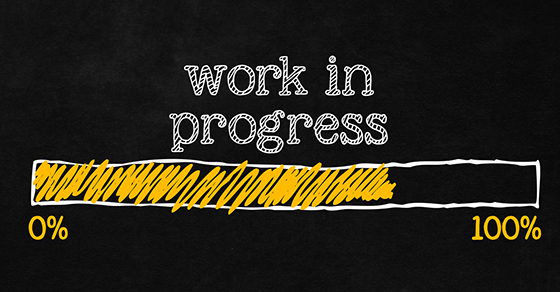